In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from pymystem3 import Mystem
from stop_words import get_stop_words
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import gensim
from gensim.models import word2vec
from sklearn.model_selection import cross_val_predict
import re
import string
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.utils import shuffle
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings('ignore')

In [2]:
ads = pd.read_csv('/Users/admin/Documents/contextAdvertising1.csv')

In [3]:
ads.shape

(799999, 3)

In [4]:
ads.head()

,atitle,atext,adomain
0,Клуб активного отдыха «0.67»,Детский пейнтбол. Спортивный пейнтбол. Тактиче...,0-67.relax.by
1,Антигравитационный чехол IPhone 5,Успейте купить антигравитационный чехол для IP...,0-antigravity.ru
2,Антигравитационный чехол купить!,Антигравитационный чехол для телефона купить з...,0-antigravity.ru
3,Беспроцентный заем от Moneyveo,Без справок! Получите до 3 000 грн. на карту п...,0-credit.moneyveo.ua
4,Беспроцентный заем сотруднику,Акция! Получите Кредит Онлайн под 0%. Без Спра...,0-credit.moneyveo.ua


In [5]:
ads.nunique()

atitle     571923
atext      350006
adomain     19181
dtype: int64

In [6]:
(ads['atitle'] + ads['atext']).nunique()

792924

In [202]:
unique_adstext =ads.drop_duplicates(subset = ['atext'], keep=False)

In [203]:
unique_adstext.nunique()

atitle     234515
atext      323003
adomain      4838
dtype: int64

In [204]:
#it appears that even after we remove duplicate ads texts, we still have duplicate titles 
unique_adstext['atitle'].nunique()

234515

In [205]:
unique =unique_adstext.drop_duplicates(subset = ['atitle'], keep=False)

In [206]:
unique.nunique()

atitle     204601
atext      204601
adomain      4589
dtype: int64

In [207]:
unique.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 204601 entries, 0 to 772521
Data columns (total 3 columns):
atitle     204601 non-null object
atext      204601 non-null object
adomain    204601 non-null object
dtypes: object(3)
memory usage: 6.2+ MB


In [208]:
unique.head()

,atitle,atext,adomain
0,Клуб активного отдыха «0.67»,Детский пейнтбол. Спортивный пейнтбол. Тактиче...,0-67.relax.by
1,Антигравитационный чехол IPhone 5,Успейте купить антигравитационный чехол для IP...,0-antigravity.ru
2,Антигравитационный чехол купить!,Антигравитационный чехол для телефона купить з...,0-antigravity.ru
3,Беспроцентный заем от Moneyveo,Без справок! Получите до 3 000 грн. на карту п...,0-credit.moneyveo.ua
4,Беспроцентный заем сотруднику,Акция! Получите Кредит Онлайн под 0%. Без Спра...,0-credit.moneyveo.ua


In [209]:
unique['atext'][:5]

0    Детский пейнтбол. Спортивный пейнтбол. Тактиче...
1    Успейте купить антигравитационный чехол для IP...
2    Антигравитационный чехол для телефона купить з...
3    Без справок! Получите до 3 000 грн. на карту п...
4    Акция! Получите Кредит Онлайн под 0%. Без Спра...
Name: atext, dtype: object

In [210]:
type(unique['atext'])

pandas.core.series.Series

In [211]:
#include all the punctuation signs\n",
def punctuation_remover(row):
    punctuation = '!"#$&\'()*+,-./:;<=>?@[\\]^_`{|}~«»'
    
    punctuationNoPeriod = "[" + re.sub("\.","", punctuation) + "]"
    row = re.sub(punctuationNoPeriod, " ", str(row))
    #to remove double white spaces and create space after %,
    row = row.replace('  ', ' ')
    row = row.replace('%', '% ')
    return row.strip()


In [212]:
punctuation_remover(unique['atext'][0])

'Детский пейнтбол Спортивный пейнтбол Тактический пейнтбол Выездные игры'

In [213]:
# remove punctuation from the ads text
unique['atext'] = unique['atext'].apply(punctuation_remover)

In [214]:
unique['atitle'] = unique['atitle'].apply(punctuation_remover)

In [215]:
unique['atitle'][:5]

0           Клуб активного отдыха 0 67
1    Антигравитационный чехол IPhone 5
2      Антигравитационный чехол купить
3       Беспроцентный заем от Moneyveo
4        Беспроцентный заем сотруднику
Name: atitle, dtype: object

In [216]:
unique['atext'].iloc[0]

'Детский пейнтбол Спортивный пейнтбол Тактический пейнтбол Выездные игры'

In [217]:
unique = unique.drop_duplicates(subset = ['atitle'], keep=False)

In [218]:
unique = unique.drop_duplicates(subset = ['atext'], keep=False)

In [24]:
unique.nunique()

atitle     200718
atext      200718
adomain      4534
dtype: int64

m = Mystem()
def text_parser(series, lemmatize=True): # do lemmatization if true 
    series_copy = series.copy()
 
    # access each ad by index
    for index in series_copy.index:
        
        text = series_copy[index]
        if lemmatize ==True:
            lemmas = m.lemmatize(text)

            lem_no_punct = [lemma for lemma in lemmas if lemma!= ' '
                           and lemma != '\n']
            
            output = lem_no_punct
        else:
            output = text.split()
        series_copy[index] =output
    return series_copy

In [192]:
m = Mystem()
def text_parser(series, lemmatize=True): # do lemmatization if true 
    series_copy = series.copy()
 
    # access each ad by index
    for index in series_copy.index:
        ad_string = ''
        text = series_copy[index]
        if lemmatize == True:
            lemmas = m.lemmatize(text)
            for count, lemma in enumerate(lemmas):
                if (lemma !=  ' ' and lemma != '\n' and count < len(lemmas)):
                    ad_string += lemma +' '
                                
        else:
            for number, word in enumerate(text):  
                if number <len(text)-1:
                    ad_string+=word +' '
            ad_string.strip()        
            #now it's actually a list of strings        
            ad_string = ad_string.strip()
            ad_string = ad_string.split() 
            
        series_copy[index] =ad_string
    return series_copy

In [26]:
unique_lem['atitle'] = text_parser(unique['atitle'])

In [27]:
unique_lem['atext'] = text_parser(unique['atext'])

In [28]:
unique_lem.head()

,atitle,atext,adomain
0,клуб активный отдых 0 67,детский пейнтбол спортивный пейнтбол тактическ...,0-67.relax.by
1,антигравитационный чехол IPhone 5,успевать купить антигравитационный чехол для I...,0-antigravity.ru
3,беспроцентный заем от Moneyveo,без справка получать до 3 000 грн на карта под...,0-credit.moneyveo.ua
4,беспроцентный заем сотрудник,акция получать кредит онлайн под 0 % без спр...,0-credit.moneyveo.ua
11,Аnti Gravity Case,Аnti gravity case – уникальный антигравитаци...,0-gravity.online-shop-2017.ru


In [29]:
unique_lem.shape

(200718, 3)

In [30]:
unique_lem = unique.drop_duplicates(subset = ['atitle'], keep=False)

In [31]:
unique_lem = unique.drop_duplicates(subset = ['atext'], keep=False)

In [32]:
unique_lem.shape

(195820, 3)

In [33]:
unique_lem.nunique()

atitle     195820
atext      195820
adomain      4492
dtype: int64

In [34]:
unique_lem = unique_lem.drop_duplicates(keep=False)

In [35]:
unique_lem.nunique()

atitle     195820
atext      195820
adomain      4492
dtype: int64

In [36]:
unique_lem.shape

(195820, 3)

In [37]:
len(set(unique_lem['atext']))

195820

In [38]:
len(set(unique_lem['atitle']))

195820

In [39]:
len(unique_lem['atitle'])

195820

In [40]:
len(unique_lem['atext'])

195820

In [41]:
unique_lem.isnull().sum()

atitle     0
atext      0
adomain    0
dtype: int64

In [42]:
unique_lem['atitle'] = unique_lem['atitle'].apply(lambda x: x.split())

In [43]:
unique_lem['atext'] = unique_lem['atext'].apply(lambda x: x.split())

In [44]:
X = unique_lem['atext']
y = unique_lem['atitle']

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [46]:
merged_list = X_train + y_train

# Training Word2Vec

In [47]:
model = word2vec.Word2Vec(
    merged_list,
    workers=4,     
    min_count=5,   
    window=50,      
    sg=0,          
    sample=1e-4 ,  
    size=300,      
    hs=1           
)


In [48]:
vocab = model.wv.vocab.keys()
print(len(vocab))

21000


In [49]:
def tsne_plot(model):
    #Creates and TSNE model and plots it
    
    labels = []
    tokens = []

    for word in model.wv.vocab:
        if model.wv.vocab[word].count > 800:
            tokens.append(model[word])
            labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=108)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(20, 20)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

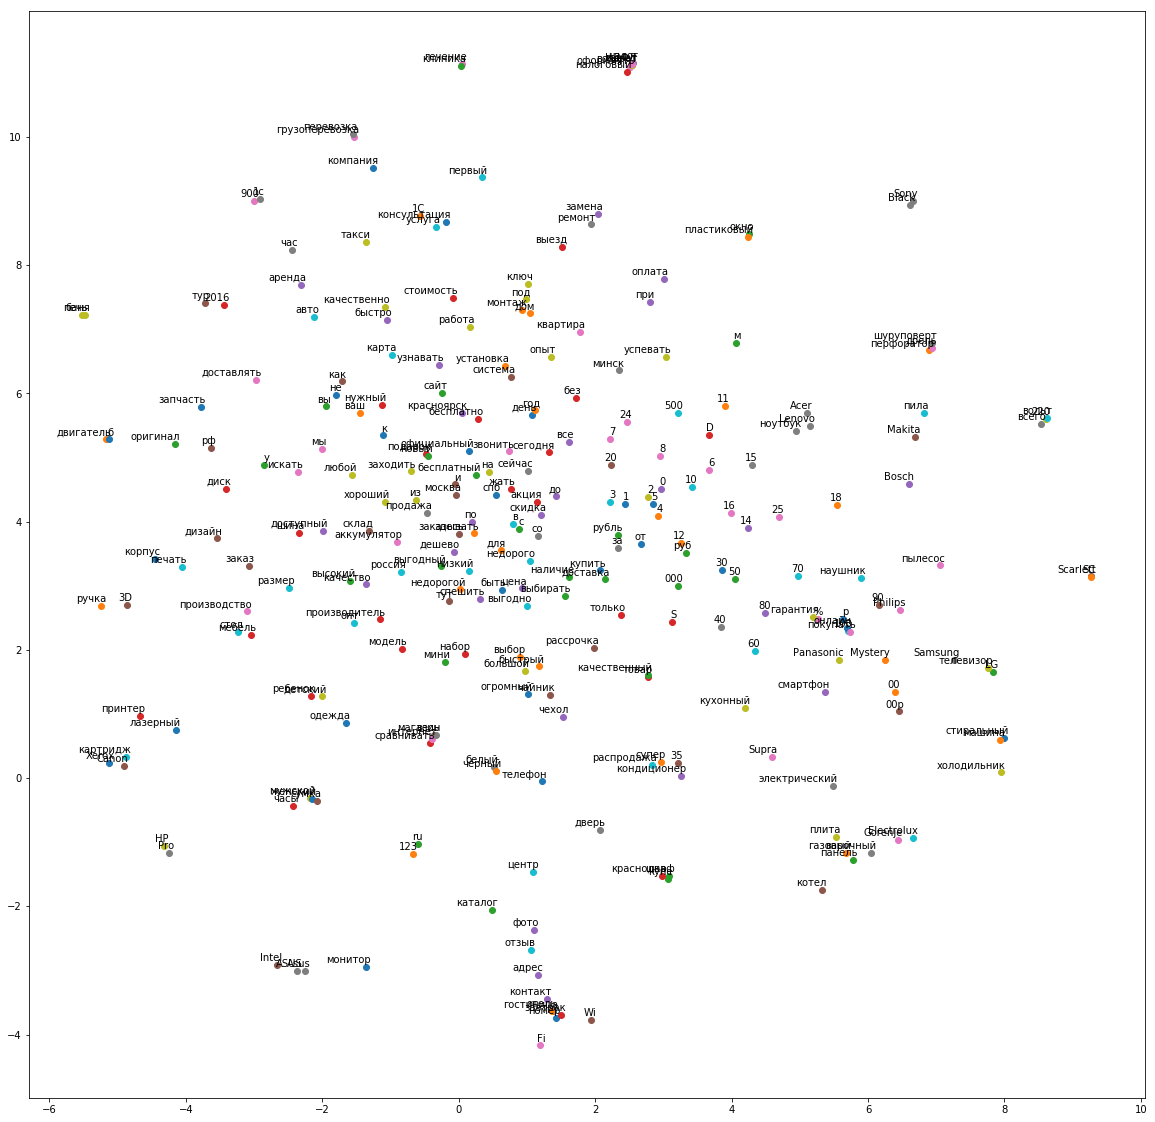

In [50]:
tsne_plot(model)

# Sample For Evaluation

In [51]:
indices = X_test.index

In [52]:
test_df = pd.DataFrame(X_test, index = indices)

In [53]:
test_df.head()

,atext
379691,"[электрочайник, Zigmund, Shtain, KE, 81, SD, 1..."
520472,"[сабвуфер, огромный, ассортимент, бесплатный, ..."
19942,"[Onkyo, Tx, nr545, Black, в, наличие, быстрый,..."
153486,"[шаблон, ордер, входить, в, состав, сборник, 1..."
700377,"[шпаклевка, финишный, белый, сравнивать, цена,..."


In [54]:
test_df['atitle'] = y_test

In [55]:
test_df.shape

(58746, 2)

In [56]:
# we can't fit all the examples in our memory

test_sample = test_df.sample(1000)

In [57]:
test_text_sample = test_sample['atext']
test_title_sample = test_sample['atitle']

In [58]:
from sklearn.preprocessing import normalize


def result_vector(text):
    result = np.zeros(300)
    count = 0
    for word in text:
        if word in vocab:
            result+=model.wv[word]
            count+=1
    if count == 0:
        return None
    #result = (result / count).reshape(1, -1)
    result = normalize(result.reshape(1, -1))     
    return result

In [59]:
ad_vectors = []
for ad_text in test_text_sample:
        vector = result_vector(ad_text)
        if vector is not None:
            ad_vectors.append(vector)
        else:
            ad_vectors.append('M')

In [60]:
title_vectors = []
for ad_title in test_title_sample:
    vector = result_vector(ad_title)
    if vector is not None:
        title_vectors.append(vector)
    else:
        title_vectors.append('M')

In [61]:
def cosine_calculator(vector_one, other_vectors):
    cosines = []
    for each in other_vectors:
        if each != 'M':
            sim_score = cosine_similarity(vector_one, each)
            cosines.extend(sim_score) 
        else:
            cosines.append('M')
    return cosines

In [62]:
def rank_checker(first_vector_set, other_vectors, smpl_df, number):
    cosines_results = cosine_calculator(first_vector_set[number], other_vectors)
    series = pd.Series(cosines_results, index =smpl_df.index)
    
    #cleaning the series for sorting, 'M' stands for missing, was added if no words in the text were found in w2v vocab
    cleaned = series[series != 'M']
    sorted_df = cleaned.sort_values(ascending=False)
    sorted_index = sorted_df.index
    
    for rank, entry in enumerate(sorted_index):
        if entry == smpl_df.index[number]:
            return rank

In [63]:
ranks = []
for row in range(len(test_sample)):
    rank = rank_checker(ad_vectors, title_vectors, test_sample, row)
    ranks.append(rank)

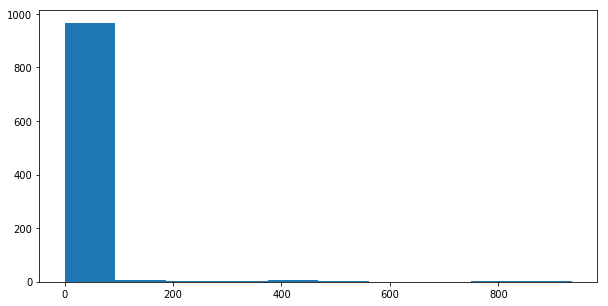

In [64]:
plt.figure(figsize=(10, 5))
plt.hist([rank for rank in ranks if rank is not None])
plt.show()

In [65]:
#average rank
sum([rank for rank in ranks if rank is not None])/ len([rank for rank in ranks if rank is not None])

15.448692152917506

In [66]:
small = []
for rank in ranks:
    if rank is not None and rank <=10:
        small.append(rank) 

In [67]:
# proportion ranked as 
len(small) / len([rank for rank in ranks if rank is not None])

0.9054325955734407

# Supervised Solution

In [68]:
training_df = pd.DataFrame()
training_df['text vectors'] = X_train 
training_df['title vectors'] = y_train

In [69]:
test_df = pd.DataFrame()
test_df['text vectors'] = X_test
test_df['title vectors'] = y_test

In [70]:
training_df.shape

(137074, 2)

In [71]:
test_df.shape

(58746, 2)

In [72]:
def mixed_df_creator(df):
    
    df_copy = df.copy()
    df_copy = df.reset_index(drop=True)
    
    first_half = df_copy.iloc[:int(len(df_copy)/2)]
    second_half = df_copy.iloc[int(len(df_copy)/2):]
    
    shuffled_titles = shuffle(second_half['title vectors'])
    shuffled_titles = shuffled_titles.reset_index(drop=True)
    
    second_half = second_half.reset_index(drop=True)
    second_half['title vectors'] = shuffled_titles
    
    first_half['pair class'] = 1
    second_half['pair class'] = 0
    
    #sim_score_one = first_half.apply(cosine_between_rows, axis = 1)
    #sim_score_two = second_half.apply(cosine_between_rows, axis = 1)
    
    #print('Mean cosine similarity score: first half', np.mean(sim_score_one))
    #print('Mean cosine similarity score: second half', np.mean(sim_score_two))
    
    concat_result = pd.concat([first_half, second_half], axis=0, ignore_index = True)
    
    return concat_result

In [73]:
training_df_mixed = mixed_df_creator(training_df)

In [74]:
test_df_mixed = mixed_df_creator(test_df)

In [75]:
training_df_mixed.head()

,text vectors,title vectors,pair class
0,"[lg, sh7b, от, 819, 00, доставка]","[lg, sh7b]",1
1,"[нужный, перевод, медицинский, документация, к...","[перевод, медицинский, документация]",1
2,"[результат, на, 3, день, зубной, паста, крест,...","[зубной, паста, крест]",1
3,"[массив, бук, и, дуб, древесный, шпон, ciplex,...","[межкомнатный, дверь, из, россия]",1
4,"[купить, Gerat, лента, пробивной, Gerat, 19мм,...","[Gerat, 19мм, 3, 2мм, 30м, 50327]",1


In [76]:
training_df_mixed.shape

(137074, 3)

In [77]:
len(result_vector(training_df_mixed.iloc[0, 0])[0])

300

In [78]:
# vectorization of the ads text
text_vectors = []
for row in range(len(training_df_mixed)):
    vector = result_vector(training_df_mixed.iloc[row, 0])
    if vector is not None:  
        text_vectors.append(vector[0])
    else:
        text_vectors.append('M')

In [79]:
training_df_mixed_vectorized = training_df_mixed.copy()

In [80]:
training_df_mixed_vectorized['text vectors'] = text_vectors

In [81]:
# vectorization of the ads text
text_vectors_test = []
for row in range(len(test_df_mixed)):
    vector = result_vector(test_df_mixed.iloc[row, 0])
    if vector is not None:  
        text_vectors_test.append(vector[0])
    else:
        text_vectors_test.append('M')

In [82]:
test_df_mixed_vectorized = test_df_mixed.copy()

In [83]:
test_df_mixed_vectorized['text vectors'] = text_vectors_test

In [84]:
# vectorization of the ads title
title_vectors_tr = []
for row in range(len(training_df_mixed)):
    vector = result_vector(training_df_mixed.iloc[row, 1])
    if vector is not None:  
        title_vectors_tr.append(vector[0])
    else:
        title_vectors_tr.append('M')

In [85]:
training_df_mixed_vectorized['title vectors'] = title_vectors_tr

In [86]:
# vectorization of the ads title
title_vectors_test = []
for row in range(len(test_df_mixed)):
    vector = result_vector(test_df_mixed.iloc[row, 1])
    if vector is not None:  
        title_vectors_test.append(vector[0])
    else:
        title_vectors_test.append('M')

In [87]:
test_df_mixed_vectorized['title vectors'] = title_vectors_test

In [88]:
# remove vectors with that are comprised exclusively of the words that are missing from our vocabulary

training_df_mixed_vectorized= training_df_mixed_vectorized[training_df_mixed_vectorized['text vectors'] != 'M']
training_df_mixed_vectorized = training_df_mixed_vectorized[training_df_mixed_vectorized['title vectors'] != 'M']

test_df_mixed_vectorized= test_df_mixed_vectorized[test_df_mixed_vectorized['text vectors'] != 'M']
test_df_mixed_vectorized = test_df_mixed_vectorized[test_df_mixed_vectorized['title vectors'] != 'M']

In [89]:
training_df_mixed_vectorized.head()

,text vectors,title vectors,pair class
0,"[-0.09769867784780527, -0.061115555833197686, ...","[-0.049366836243145445, -0.03596356067177696, ...",1
1,"[-0.09798052369211248, 0.026822177874674155, 0...","[-0.043635531786860325, 0.03474029436104697, 0...",1
2,"[-0.11090856274964765, 0.09939087001422438, -0...","[-0.022173429932130923, 0.10627881093602322, 0...",1
3,"[-0.05994962719710779, 0.007375251393904025, -...","[-0.03757043483240444, -0.021373082798897842, ...",1
4,"[0.013162675176291569, 0.09739772888436832, -0...","[0.040101978243317925, 0.0903473107753642, -0....",1


In [90]:
test_df_mixed_vectorized.head()

,text vectors,title vectors,pair class
0,"[-0.07165920886421723, 0.06565242621313824, -0...","[-0.021773104500447626, 0.05458610764250942, -...",1
1,"[-0.10686254860108933, 0.08799862882607107, 0....","[-0.06523840541462018, 0.1210428454629412, 0.0...",1
2,"[-0.14737444500252272, 0.0477685306188213, 0.0...","[-0.09333348265327508, 0.057961477782754026, 0...",1
3,"[-0.10900243069439122, 0.04217269800107119, 0....","[-0.052745812736997785, 0.02359298494622693, 0...",1
4,"[-0.0052876368459525945, 0.1345028153217125, 0...","[-0.009416259585892602, 0.16921837183912025, 0...",1


In [91]:
def cosine_between_rows(row):
    sim = cosine_similarity(row['text vectors'].reshape(1, -1), row['title vectors'].reshape(1, -1))
    return sim

# Cosine Consistency Check

In [92]:
sim_score_one = training_df_mixed_vectorized.iloc[:int(len(training_df_mixed_vectorized)/2)].apply(cosine_between_rows, axis = 1)
sim_score_two = training_df_mixed_vectorized.iloc[int(len(training_df_mixed_vectorized)/2):].apply(cosine_between_rows, axis = 1)

print('Mean cosine similarity score: first half', np.mean(sim_score_one))
print('Mean cosine similarity score: second half', np.mean(sim_score_two))

Mean cosine similarity score: first half [[0.77849091]]
Mean cosine similarity score: second half [[0.2391495]]


In [93]:
sim_score_one_test = test_df_mixed_vectorized.iloc[:int(len(test_df_mixed_vectorized)/2)].apply(cosine_between_rows, axis = 1)
sim_score_two_test = test_df_mixed_vectorized.iloc[int(len(test_df_mixed_vectorized)/2):].apply(cosine_between_rows, axis = 1)

print('Mean cosine similarity score: first half', np.mean(sim_score_one_test))
print('Mean cosine similarity score: second half', np.mean(sim_score_two_test))

Mean cosine similarity score: first half [[0.77177651]]
Mean cosine similarity score: second half [[0.24133522]]


In [94]:
training_df_mixed.head()

,text vectors,title vectors,pair class
0,"[lg, sh7b, от, 819, 00, доставка]","[lg, sh7b]",1
1,"[нужный, перевод, медицинский, документация, к...","[перевод, медицинский, документация]",1
2,"[результат, на, 3, день, зубной, паста, крест,...","[зубной, паста, крест]",1
3,"[массив, бук, и, дуб, древесный, шпон, ciplex,...","[межкомнатный, дверь, из, россия]",1
4,"[купить, Gerat, лента, пробивной, Gerat, 19мм,...","[Gerat, 19мм, 3, 2мм, 30м, 50327]",1


In [95]:
training_df_mixed.isnull().sum()

text vectors     0
title vectors    0
pair class       0
dtype: int64

In [96]:
training_df_mixed.head()

,text vectors,title vectors,pair class
0,"[lg, sh7b, от, 819, 00, доставка]","[lg, sh7b]",1
1,"[нужный, перевод, медицинский, документация, к...","[перевод, медицинский, документация]",1
2,"[результат, на, 3, день, зубной, паста, крест,...","[зубной, паста, крест]",1
3,"[массив, бук, и, дуб, древесный, шпон, ciplex,...","[межкомнатный, дверь, из, россия]",1
4,"[купить, Gerat, лента, пробивной, Gerat, 19мм,...","[Gerat, 19мм, 3, 2мм, 30м, 50327]",1


In [97]:
test_df_mixed.isnull().sum()

text vectors     0
title vectors    0
pair class       0
dtype: int64

In [98]:
def df_converter(df):
    resultant_lists = df['text vectors'].apply(list) + df['title vectors'].apply(list)
    
    #print length for checking the length of concatenated vectors
    print(len(resultant_lists.iloc[0]))
    
    arrays = np.array(list(resultant_lists))
    return arrays

In [99]:
test_sample.head()

,atext,atitle
699034,"[чайник, Leran, сравнивать, цена, весь, интерн...","[чайник, Leran]"
34195,"[большой, выбор, ростест, микроволновый, печь,...","[микроволновка, в, магазин, 003, ru]"
665881,"[подарок, на, юбилей, свадьба, фото, светильни...","[подарок, на, юбилей, свадьба]"
679769,"[краска, Feidal, сравнивать, цена, весь, интер...","[краска, Feidal]"
623898,"[новый, модель, час, AMST, оценивать, успевать...","[новый, час, AMST, официальный, сайт]"


In [100]:
test_sample.shape

(1000, 2)

In [101]:
all_training_vectors = df_converter(training_df_mixed_vectorized)

600


In [102]:
all_test_vectors = df_converter(test_df_mixed_vectorized)

600


In [103]:
new_y_training = training_df_mixed_vectorized['pair class']

In [104]:
new_y_test = test_df_mixed_vectorized['pair class']

# Sample for Parameter Finetuning

In [105]:
sample_training_df = training_df_mixed_vectorized.sample(10000)

In [106]:
sample_training_df.head()

,text vectors,title vectors,pair class
57905,"[-0.0504131020293922, 0.08136678893901808, -0....","[-0.06235598104714084, 0.14457928839957465, -0...",1
15340,"[-0.0360864246983486, 0.06547344394431176, 0.0...","[-0.09102079018199796, 0.08779689875695544, 0....",1
85891,"[-0.01304844969234746, -0.07018732798111822, 0...","[-0.05438633666481561, 0.12815890926114604, 0....",0
81420,"[-0.05223521163737365, 0.02359936182591435, -0...","[-0.04939974110747408, 0.11568968879082427, 0....",0
68899,"[-0.11219315906395994, -0.0053895539108838025,...","[-0.041891985072558556, 0.15006687582318132, -...",0


In [107]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 150)
X_train_pca = pca.fit_transform(all_training_vectors)

In [108]:
print(sum(pca.explained_variance_ratio_))

0.8763373428311206


In [109]:
X_test_pca = pca.transform(all_test_vectors)

In [110]:
X_test_pca.shape

(58275, 150)

# Finetuning Models

In [111]:
sample_training_arrays = df_converter(sample_training_df)

600


In [112]:
sample_y = sample_training_df['pair class']

In [113]:
pca_sample = PCA(n_components = 150)
X_train_sample_pca = pca_sample.fit_transform(sample_training_arrays)

In [114]:
X_train_sample_pca.shape

(10000, 150)

In [115]:
print(sum(pca_sample.explained_variance_ratio_))

0.8788698224166304


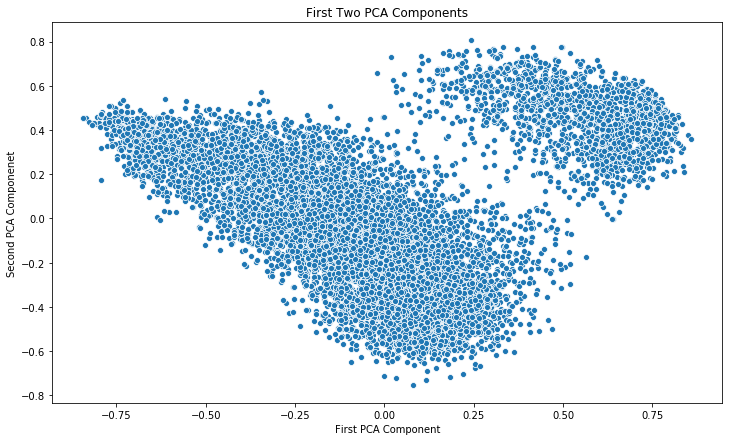

In [116]:
plt.figure(figsize=(12, 7))
plt.title('First Two PCA Components')
sns.scatterplot(X_train_sample_pca[:, 0], X_train_sample_pca[:, 1])
plt.xlabel('First PCA Component')
plt.ylabel('Second PCA Componenet')

plt.show()

In [117]:
from sklearn.linear_model import LogisticRegression

param_grid = [
    {'C': [1e-20, 1e-3,1e-3,  10, 1e2, 1e3],
    'penalty': ['l1', 'l2']}
]
lr = LogisticRegression()

grid_search = GridSearchCV(lr, param_grid, cv =3,
                          scoring= 'accuracy', verbose=1)

grid_search.fit(X_train_sample_pca, sample_y)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:    2.3s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'C': [1e-20, 0.001, 0.001, 10, 100.0, 1000.0], 'penalty': ['l1', 'l2']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=1)

In [118]:
print('Best score', grid_search.best_score_)
print('Best parameters', grid_search.best_params_)

Best score 0.5051
Best parameters {'C': 10, 'penalty': 'l2'}


In [119]:
param_grid_rfc = [
    {'n_estimators': [100, 500, 700],
    'max_depth': [5, 8, 12, 20, 30]}
]
rfc = RandomForestClassifier(n_jobs = -1)

grid_search_rfc = GridSearchCV(rfc, param_grid_rfc, cv =3,
                          scoring= 'accuracy', verbose=0,
                          n_jobs = -1)

grid_search_rfc.fit(X_train_sample_pca, sample_y)

GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'n_estimators': [100, 500, 700], 'max_depth': [5, 8, 12, 20, 30]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [120]:
print('Best score', grid_search_rfc.best_score_)
print('Best parameters', grid_search_rfc.best_params_)

Best score 0.886
Best parameters {'max_depth': 30, 'n_estimators': 700}


In [121]:
param_grid_rfc = [
    {'n_estimators': [1000, 1200],
    'max_depth': [40, 50]}
]
rfc_one = RandomForestClassifier(n_jobs = -1)

grid_search_rfc_one = GridSearchCV(rfc, param_grid_rfc, cv =3,
                          scoring= 'accuracy', verbose=0,
                          n_jobs = -1)

grid_search_rfc_one.fit(X_train_sample_pca, sample_y)

GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'n_estimators': [1000, 1200], 'max_depth': [40, 50]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [122]:
print('Best score', grid_search_rfc_one.best_score_)
print('Best parameters', grid_search_rfc_one.best_params_)

Best score 0.8881
Best parameters {'max_depth': 40, 'n_estimators': 1200}


In [123]:
from xgboost import XGBClassifier

param_grid_xgb = [
    {'n_estimators': [100, 500, 700],
    'max_depth': [2, 4, 6, 8],
    #'learning_rate': [1e-3, 0.5, 0.1],
    }
]
xgb = XGBClassifier(n_jobs = -1)

grid_search_xgb = GridSearchCV(xgb, param_grid_xgb, cv =3,
                          scoring= 'accuracy', verbose=0,
                          n_jobs = -1)

grid_search_xgb.fit(X_train_sample_pca, sample_y)

GridSearchCV(cv=3, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'n_estimators': [100, 500, 700], 'max_depth': [2, 4, 6, 8]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [124]:
print('Best score', grid_search_xgb.best_score_)
print('Best parameters', grid_search_xgb.best_params_)

Best score 0.9227
Best parameters {'max_depth': 6, 'n_estimators': 700}


In [125]:
param_grid_xgb_one = [
    {'n_estimators': [700, 1000],
    'learning_rate': [1e-3, 0.5, 0.1],
    }
]
xgb = XGBClassifier(n_jobs = -1, max_depth= 6)

grid_search_xgb_one = GridSearchCV(xgb, param_grid_xgb_one, cv =3,
                          scoring= 'accuracy', verbose=0,
                          n_jobs = -1)

grid_search_xgb_one.fit(X_train_sample_pca, sample_y)

GridSearchCV(cv=3, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=6, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'n_estimators': [700, 1000], 'learning_rate': [0.001, 0.5, 0.1]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [126]:
print('Best score', grid_search_xgb_one.best_score_)
print('Best parameters', grid_search_xgb_one.best_params_)

Best score 0.9255
Best parameters {'learning_rate': 0.1, 'n_estimators': 1000}


In [127]:
param_grid_xgb_two = [
    {'subsample': [0.25, 0.5, 1],
    }
]
xgb = XGBClassifier(n_jobs = -1, max_depth= 6, n_estimators=1000, learning_rate=0.1, )

grid_search_xgb_two = GridSearchCV(xgb, param_grid_xgb_two, cv =3,
                          scoring= 'accuracy', verbose=0,
                          n_jobs = -1)

grid_search_xgb_two.fit(X_train_sample_pca, sample_y)

GridSearchCV(cv=3, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=6, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'subsample': [0.25, 0.5, 1]}], pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='accuracy',
       verbose=0)

In [128]:
print('Best score', grid_search_xgb_two.best_score_)
print('Best parameters', grid_search_xgb_two.best_params_)

Best score 0.9262
Best parameters {'subsample': 0.5}


# Test Set

In [173]:
from sklearn.metrics import roc_auc_score
lr_test = LogisticRegression(C= 10, penalty= 'l2')

lr_test.fit(X_train_pca, new_y_training)

print(lr_test.score(X_test_pca, new_y_test))

0.4998198198198198


In [174]:
rfc_test = RandomForestClassifier(n_jobs = -1, 
                            n_estimators = 1200,
                            max_depth = 40)

rfc_test.fit(X_train_pca, new_y_training)

print(rfc_test.score(X_test_pca, new_y_test))

0.9361475761475762


In [131]:
xgb_test = XGBClassifier(n_estimators = 1000,
                        max_depth = 6,
                        learning_rate= 0.1,
                        subsample = 0.5)

xgb_test.fit(X_train_pca, new_y_training)

print(xgb_test.score(X_test_pca, new_y_test))

0.9646503646503647


In [132]:
print(xgb_test.score(X_test_pca, new_y_test))

0.9646503646503647


In [133]:
len(X_test_pca)

58275

In [134]:
len(test_df_mixed['text vectors'])

58746

In [135]:
predictions = pd.DataFrame(test_df_mixed['text vectors'].iloc[:200])
predictions['title vectors'] = test_df_mixed['title vectors'].iloc[:200]
predictions['pair class'] = test_df_mixed['pair class'].iloc[:200]
predictions['predicted class'] = xgb_test.predict_proba(X_test_pca[:200])[:, 1]

In [136]:
xgb_test.predict_proba(X_test_pca[0].reshape(1, -1))[:, 1]

array([0.9795941], dtype=float32)

In [137]:
predictions

,text vectors,title vectors,pair class,predicted class
0,"[электрочайник, Zigmund, Shtain, KE, 81, SD, 1...","[KE, 81, SD, 119, 00, р]",1,0.979594
1,"[сабвуфер, огромный, ассортимент, бесплатный, ...","[сабвуфер, купить, в, красноярск]",1,0.989562
2,"[Onkyo, Tx, nr545, Black, в, наличие, быстрый,...","[Onkyo, Tx, nr545, Black, всего, 42390р]",1,0.998748
3,"[шаблон, ордер, входить, в, состав, сборник, 1...","[шаблон, ордер]",1,0.983236
4,"[шпаклевка, финишный, белый, сравнивать, цена,...","[шпаклевка, финишный, белый]",1,0.984698
5,"[акция, аккумулятор, на, Toyota, Corolla, розн...","[аккумулятор, на, Toyota, Corolla]",1,0.994536
6,"[пила, торцовочный, только, сегодня, за, 6499,...","[пила, торцовочный, Hammer]",1,0.971493
7,"[по, низкий, цена, шуруповерт, макит, в, спб, ...","[купить, шуруповерт, макит, в, спб]",1,0.993659
8,"[купить, Makita, уровень, Makita, Skr200z, 174...","[уровень, Makita, Skr200z, 174614]",1,0.989779
9,"[дезодорант, регулир, потоотделение, сравниват...","[дезодорант, регулир, потоотделение]",1,0.991353


In [138]:
predictions = pd.DataFrame(test_df_mixed['text vectors'].iloc[-200:])
predictions['title vectors'] = test_df_mixed['title vectors'].iloc[-200:]
predictions['pair class'] = test_df_mixed['pair class'].iloc[-200:]
predictions['predicted class'] = xgb_test.predict_proba(X_test_pca[-200:])[:, 1]

In [139]:
X_test_pca[0].shape

(150,)

In [140]:
predictions

,text vectors,title vectors,pair class,predicted class
58546,"[адресный, табличка, изготовление, 1, день, бо...","[Prology, iOne, 1000, 467, 15, руб]",0,0.001919
58547,"[телефон, Highscreen, Boost, сравнивать, цена,...","[совместный, покупка, ярославль]",0,0.000343
58548,"[электродный, котел, сравнивать, цена, весь, и...","[бампер, на, Opel, Astra, H]",0,0.000313
58549,"[быть, в, наличие, сейчас, рубанок, BLACK, AND...","[микроскоп, levenhuk, 2l]",0,0.078692
58550,"[мфу, Brother, DCP, J100, 360, 86, р, гарантия...","[Brother, DCP, L2540DNR, 584, 38, р]",0,0.989911
58551,"[наушник, вкладыш, большой, выбор, наушник, по...","[ст, 222, ук, рф, 100, юрист]",0,0.001256
58552,"[звонить, сейчас, купить, дом, на, авито, стро...","[аккумулятор, для, K50AB]",0,0.024118
58553,"[имплантация, и, профессиональный, протезирова...","[мариборский, университет, жать]",0,0.314296
58554,"[холодильник, Liebherr, CTP, 3316, низкий, цен...","[согласование, наружный, реклама]",0,0.000268
58555,"[жакет, теплый, сравнивать, цена, весь, интерн...","[benq, bl2710pt]",0,0.000319


In [141]:
from sklearn.metrics import f1_score
print(f1_score(new_y_test, xgb_test.predict(X_test_pca)))

0.9645536513180536


In [142]:
from sklearn.metrics import confusion_matrix
confusion_matrix(new_y_test, xgb_test.predict(X_test_pca))

array([[28187,   937],
       [ 1123, 28028]])

In [143]:
28307 / (577+28307)

0.9800235424456446

In [144]:
28307 / (28307+918)

0.9685885372112917

In [145]:
sample_test_df_checking = test_df.sample(1000)

In [146]:
sample_test_df_checking = sample_test_df_checking.reset_index(drop=True)

In [147]:
sample_test_df_checking.head()

,text vectors,title vectors
0,"[Makita, 6271DWALE, от, 235, 38, доставка]","[Makita, 6271DWALE]"
1,"[за, 3, 642, 900, руб, доставка, по, минск, и,...","[пылесос, Zelmer, Aquawelt]"
2,"[в, наличие, за, 7582, руб, купить]","[Apple, MC380ZM, A]"
3,"[цена, весь, 5990, руб, купить, тележка, стелл...","[тележка, стелла, кг, 200, 200, к]"
4,"[Midea, AG720C4E, S, от, 170, 00, доставка]","[Midea, AG720C4E, S]"


In [148]:
sample_text_vectors_test = []
for row in range(len(sample_test_df_checking)):
    vector = result_vector(sample_test_df_checking.iloc[row, 0])
    if vector is not None:  
        sample_text_vectors_test.append(vector[0])
    else:
        sample_text_vectors_test.append('M')

In [149]:
sample_title_vectors_test = []
for row in range(len(sample_test_df_checking)):
    vector = result_vector(sample_test_df_checking.iloc[row, 1])
    if vector is not None:  
        sample_title_vectors_test.append(vector[0])
    else:
        sample_title_vectors_test.append('M')

In [150]:
test_sample_vectorized = sample_test_df_checking.copy()
test_sample_vectorized['text vectors'] = sample_text_vectors_test
test_sample_vectorized['title vectors'] = sample_title_vectors_test

In [151]:
test_sample_vectorized.head()

,text vectors,title vectors
0,"[-0.07741342707831118, 0.009104698882593798, 0...","[-0.10981967396141039, 0.09589167317070307, 0...."
1,"[-0.10288560861624262, -0.018997420775732545, ...","[0.0029413074567309896, 0.1325308551348102, -0..."
2,"[-0.0669456356892245, -0.023643816085802218, 0...","[-0.07117571241447762, 0.08119260450467572, 0...."
3,"[0.027217537280122918, 0.06741822372676884, 0....","[0.06424847283112275, 0.0646537771815778, 0.03..."
4,"[-0.14168974802620438, -0.0182662583636299, -0...","[-0.15206502215293005, 0.05999680345805086, -0..."


In [152]:
test_sample_vectorized.shape

(1000, 2)

In [153]:
test_sample_vectorized= test_sample_vectorized[test_sample_vectorized['text vectors'] != 'M']
test_sample_vectorized = test_sample_vectorized[test_sample_vectorized['title vectors'] != 'M']

In [154]:
test_sample_vectorized.shape

(993, 2)

In [155]:
def probability_calculator(text_vector, title_vectors):
    probs = []
    for each in title_vectors:
        resultant_list = list(text_vector) +list(each)
        resultant_array = np.array(list(resultant_list))
        
        array_pca_tr = pca.transform(resultant_array.reshape(1,- 1))
        probability = xgb_test.predict_proba(array_pca_tr.reshape(1, -1))[:, 1]
        
        probs.extend(probability)
        
    return probs

In [156]:
def rank_checker_prob (df, number):
    probabilities = probability_calculator(df.iloc[number, 0], df.iloc[:, 1])
    series = pd.Series(probabilities, index =df.index)

    sorted_df = series.sort_values(ascending=False)
    sorted_index = sorted_df.index
    
    for rank, entry in enumerate(sorted_index):
        if entry == df.index[number]:
            return rank

In [157]:
test_sample_vectorized.index[0]

0

In [158]:
test_sample_vectorized.index

Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
            990, 991, 992, 993, 994, 995, 996, 997, 998, 999],
           dtype='int64', length=993)

In [159]:
ranks = []
for row in range(len(test_sample_vectorized)):     
    rank = rank_checker_prob(test_sample_vectorized, row)
    ranks.append(rank)

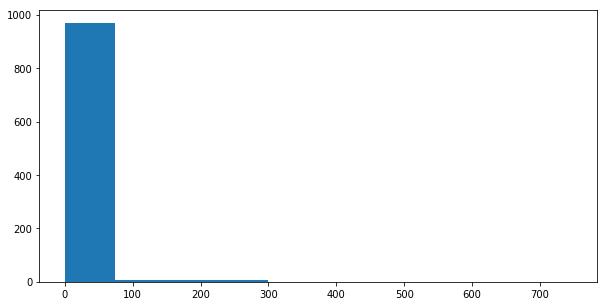

In [160]:
plt.figure(figsize=(10, 5))
plt.hist([rank for rank in ranks if rank is not None])
plt.show()

In [161]:
np.mean(ranks)

8.198388721047332

In [162]:
small = []
for val in ranks:
    if val <=3:
        small.append(val)       

In [163]:
print('Proportion of the correct titles at a rank equal or lower than three:', len(small) / 1000)

Proportion of the correct titles at a rank equal or lower than three: 0.836


In [164]:
training_df_mixed.head()

,text vectors,title vectors,pair class
0,"[lg, sh7b, от, 819, 00, доставка]","[lg, sh7b]",1
1,"[нужный, перевод, медицинский, документация, к...","[перевод, медицинский, документация]",1
2,"[результат, на, 3, день, зубной, паста, крест,...","[зубной, паста, крест]",1
3,"[массив, бук, и, дуб, древесный, шпон, ciplex,...","[межкомнатный, дверь, из, россия]",1
4,"[купить, Gerat, лента, пробивной, Gerat, 19мм,...","[Gerat, 19мм, 3, 2мм, 30м, 50327]",1


In [165]:
training_df_mixed.iloc[:5, 1]

0                              [lg, sh7b]
1    [перевод, медицинский, документация]
2                  [зубной, паста, крест]
3       [межкомнатный, дверь, из, россия]
4       [Gerat, 19мм, 3, 2мм, 30м, 50327]
Name: title vectors, dtype: object

In [166]:
merged_trainig_examples = training_df_mixed.iloc[:, 1]+training_df_mixed.iloc[:, 0]

In [167]:
len(merged_trainig_examples)

137074

In [168]:
merged_test_examples = test_df_mixed.iloc[:, 1]+test_df_mixed.iloc[:, 0]

In [169]:
len(merged_test_examples)

58746

In [170]:
max([len(x) for x in merged_trainig_examples])

30

In [171]:
max([len(x) for x in merged_test_examples])

29

In [358]:
training_df_mixed['concatenated_text_title'] = training_df_mixed['text vectors'] + training_df_mixed['title vectors']

In [359]:
test_df_mixed['concatenated_text_title'] = test_df_mixed['text vectors'] + test_df_mixed['title vectors']

In [360]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(training_df_mixed['concatenated_text_title'])
total_words = len(tokenizer.word_index)+1

def tokenization(texts):
    
    input_sequences = []
    for ad in texts:
        token_list = tokenizer.texts_to_sequences([ad])
        input_sequences.append(token_list)
            
    return input_sequences

In [361]:
total_words

71515

In [362]:
len(input_sequences)

137074

In [364]:
input_sequences_test= generate_inputs(test_df_mixed['concatenated_text_title'])

In [365]:
len(input_sequences_test)

58746

In [366]:
test_df_mixed['concatenated_text_title'].head()

0    [электрочайник, Zigmund, Shtain, KE, 81, SD, 1...
1    [сабвуфер, огромный, ассортимент, бесплатный, ...
2    [Onkyo, Tx, nr545, Black, в, наличие, быстрый,...
3    [шаблон, ордер, входить, в, состав, сборник, 1...
4    [шпаклевка, финишный, белый, сравнивать, цена,...
Name: concatenated_text_title, dtype: object

In [367]:
training_df_mixed['concatenated_text_title'][1]

['нужный',
 'перевод',
 'медицинский',
 'документация',
 'качество',
 'и',
 'скорость',
 'звонить',
 'сейчас',
 'перевод',
 'медицинский',
 'документация']

In [372]:
import keras.utils as ku 
from keras.preprocessing.sequence import pad_sequences

max_sequence_len = max([len(entry) for entry in input_sequences])

def generate_padded_sequences(input_sequences):
    input_sequences_copy = np.array(pad_sequences(input_sequences, 
                                                  maxlen=max_sequence_len,
                                                  padding = 'post'))
    return input_sequences_copy

In [369]:
padded_sequences_test = generate_padded_sequences(input_sequences_test)

In [370]:
len(padded_sequences)

137074

In [371]:
padded_sequences_test[1]

array([1436,  178,  319,   52,    7, 1436,    2,    3,  133,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0], dtype=int32)

In [373]:
padded_sequences = generate_padded_sequences(input_sequences)

In [374]:
import keras
from keras.utils import to_categorical
y_reshaped_tr = ku.to_categorical(training_df_mixed['pair class'], 2)
y_reshaped_test = ku.to_categorical(test_df_mixed['pair class'], 2)

In [375]:
len(padded_sequences[0])

30

In [376]:
len(padded_sequences_test[0])

30

In [377]:
padded_sequences_resh = padded_sequences.reshape(137074, 30, 1)

In [378]:
padded_sequences_test.shape

(58746, 30)

In [379]:
padded_sequences_test.shape

(58746, 30)

In [380]:
padded_sequences_test_resh = padded_sequences_test.reshape(58746, 30, 1)

In [385]:
padded_sequences_test_resh.shape

(58746, 30, 1)

In [386]:
padded_sequences[0]

array([   45, 30151,     9,  5859,    24,     7,    45, 30151,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0], dtype=int32)

In [403]:
padded_sequences_resh[100]

array([[443],
       [141],
       [  9],
       [ 67],
       [  3],
       [184],
       [ 26],
       [  1],
       [443],
       [141],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0]], dtype=int32)

In [401]:
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, Dropout, Embedding

model_rnn = Sequential()
model_rnn.add(SimpleRNN(100, input_shape=(30, 1), activation = 'relu'))

model_rnn.add(Dense(2, activation='softmax'))
#model_rnn.add(Dropout(0.2))
#model.add(LSTM(400))
model_rnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])

model_rnn.fit(padded_sequences_resh, y_reshaped_tr, epochs=10, verbose = 1, validation_data = (padded_sequences_test_resh, y_reshaped_test))

Train on 137074 samples, validate on 58746 samples
Epoch 1/10
137074/137074 [==============================] - 80s 586us/step - loss: 0.7003 - acc: 0.5162 - val_loss: 0.7309 - val_acc: 0.5234
Epoch 2/10
137074/137074 [==============================] - 82s 596us/step - loss: 0.6926 - acc: 0.5176 - val_loss: 0.6965 - val_acc: 0.5072
Epoch 3/10
137074/137074 [==============================] - 82s 597us/step - loss: 0.6981 - acc: 0.5036 - val_loss: 0.6938 - val_acc: 0.5000
Epoch 4/10
137074/137074 [==============================] - 82s 601us/step - loss: 0.6979 - acc: 0.4993 - val_loss: 0.6956 - val_acc: 0.5000
Epoch 5/10
137074/137074 [==============================] - 83s 603us/step - loss: 0.6982 - acc: 0.5019 - val_loss: 0.6983 - val_acc: 0.5000
Epoch 6/10
137074/137074 [==============================] - 83s 605us/step - loss: 0.6981 - acc: 0.4972 - val_loss: 0.6942 - val_acc: 0.5000
Epoch 7/10
 23776/137074 [====>.........................] - ETA: 1:01 - loss: 0.6976 - acc: 0.5039

KeyboardInterrupt: 

In [405]:
word_vectors = model.wv

In [406]:
print("Number of word vectors: {}".format(len(word_vectors.vocab)))

Number of word vectors: 21000


In [408]:
model.wv.most_similar_cosmul(positive=['компьютер']) #negative=['man'])

[('настройка', 0.7556005716323853),
 ('Multitronics', 0.7483257055282593),
 ('изучать', 0.7379061579704285),
 ('чистка', 0.7377749681472778),
 ('пк', 0.7289078831672668),
 ('Deepcool', 0.7288321256637573),
 ('обслуживание', 0.7271099090576172),
 ('починять', 0.7255391478538513),
 ('компьютерный', 0.7254411578178406),
 ('администратор', 0.7243830561637878)]

In [409]:
MAX_NB_WORDS = len(word_vectors.vocab)
MAX_SEQUENCE_LENGTH = 30

In [422]:
from collections import Counter
vocab=Counter()

for entry in training_df_mixed['concatenated_text_title']:
    vocab.update(entry)

In [423]:
vocab.most_common()

[('цена', 48732),
 ('купить', 40943),
 ('в', 37718),
 ('магазин', 27274),
 ('весь', 26879),
 ('интернет', 25764),
 ('доставка', 25010),
 ('сравнивать', 22934),
 ('от', 22185),
 ('гарантия', 21598),
 ('для', 20917),
 ('р', 18634),
 ('%', 18626),
 ('на', 18125),
 ('руб', 15672),
 ('100', 14091),
 ('и', 13066),
 ('по', 12769),
 ('звонить', 10626),
 ('с', 10149),
 ('недорого', 9973),
 ('за', 9855),
 ('скидка', 9501),
 ('00', 9088),
 ('жать', 8882),
 ('низкий', 7841),
 ('наличие', 6990),
 ('1', 6968),
 ('3', 6461),
 ('день', 5711),
 ('онлайн', 5359),
 ('покупать', 5089),
 ('2', 4864),
 ('москва', 4612),
 ('выбор', 4599),
 ('акция', 4293),
 ('Bosch', 4099),
 ('заказывать', 4040),
 ('HP', 3841),
 ('5', 3839),
 ('год', 3795),
 ('большой', 3467),
 ('до', 3460),
 ('из', 3298),
 ('Samsung', 3245),
 ('быстрый', 3141),
 ('без', 3127),
 ('220', 3099),
 ('10', 3016),
 ('бесплатный', 2960),
 ('чехол', 2941),
 ('рф', 2938),
 ('LG', 2903),
 ('у', 2893),
 ('машина', 2829),
 ('20', 2797),
 ('НДФЛ', 2728),

In [424]:
word_index = {t[0]: i+1 for i,t in enumerate(vocab.most_common(MAX_NB_WORDS))}

In [425]:
training_sequences = [[word_index.get(t, 0) for t in ad_title_combo]
             for ad_title_combo in training_df_mixed['concatenated_text_title']]

In [426]:
test_sequences = [[word_index.get(t, 0)  for t in ad_title_combo] 
                  for ad_title_combo in test_df_mixed['concatenated_text_title']]

In [428]:
# pad sequences
data = pad_sequences(training_sequences, maxlen=MAX_SEQUENCE_LENGTH, 
                     padding="pre", truncating="post")

In [433]:
training_df_mixed.head()

,text vectors,title vectors,pair class,concatenated_text_title
0,"[lg, sh7b, от, 819, 00, доставка]","[lg, sh7b]",1,"[lg, sh7b, от, 819, 00, доставка, lg, sh7b]"
1,"[нужный, перевод, медицинский, документация, к...","[перевод, медицинский, документация]",1,"[нужный, перевод, медицинский, документация, к..."
2,"[результат, на, 3, день, зубной, паста, крест,...","[зубной, паста, крест]",1,"[результат, на, 3, день, зубной, паста, крест,..."
3,"[массив, бук, и, дуб, древесный, шпон, ciplex,...","[межкомнатный, дверь, из, россия]",1,"[массив, бук, и, дуб, древесный, шпон, ciplex,..."
4,"[купить, Gerat, лента, пробивной, Gerat, 19мм,...","[Gerat, 19мм, 3, 2мм, 30м, 50327]",1,"[купить, Gerat, лента, пробивной, Gerat, 19мм,..."


In [436]:
data.shape

(137074, 30)

In [438]:
# pad sequences
test_data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH, 
                     padding="pre", truncating="post")

In [440]:
test_data.shape

(58746, 30)

In [443]:
y_reshaped_tr.shape

(137074, 2)

In [444]:
y_reshaped_test.shape

(58746, 2)

In [445]:
WV_DIM = 300
nb_words = min(MAX_NB_WORDS, len(word_vectors.vocab))

# we initialize the matrix with random numbers
wv_matrix = (np.random.rand(nb_words, WV_DIM) - 0.5) / 5.0
for word, i in word_index.items():
    if i >= MAX_NB_WORDS:
        continue
    try:
        embedding_vector = word_vectors[word]
        # words not found in embedding index will be all-zeros.
        wv_matrix[i] = embedding_vector
    except:
        pass  

In [454]:
from keras.layers import Dense, Input, Embedding, Dropout,SpatialDropout1D, Bidirectional, LSTM
from keras.models import Model
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization

In [459]:
wv_layer = Embedding(nb_words,
                     WV_DIM,
                     mask_zero=False,
                     weights=[wv_matrix],
                     input_length=MAX_SEQUENCE_LENGTH,
                     trainable=False)

# Inputs
comment_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = wv_layer(comment_input)


embedded_sequences = SpatialDropout1D(0.2)(embedded_sequences)
x = Bidirectional(LSTM(64, return_sequences=False))(embedded_sequences)

# Output
x = Dropout(0.2)(x)
x = BatchNormalization()(x)
preds = Dense(2, activation='sigmoid')(x)

# build the model
model = Model(inputs=[comment_input], outputs=preds)
model.compile(loss='binary_crossentropy',
              optimizer=Adam(lr=0.001, clipnorm=.25, beta_1=0.7, beta_2=0.99),
              metrics=[])


InvalidArgumentError: No OpKernel was registered to support Op 'CudnnRNN' with these attrs.  Registered devices: [CPU], Registered kernels:
  <no registered kernels>

	 [[Node: bidirectional_1/CudnnRNN = CudnnRNN[T=DT_FLOAT, direction="unidirectional", dropout=0, input_mode="linear_input", is_training=true, rnn_mode="lstm", seed=87654321, seed2=0](bidirectional_1/transpose, bidirectional_1/ExpandDims_1, bidirectional_1/ExpandDims_2, bidirectional_1/concat)]]

Caused by op 'bidirectional_1/CudnnRNN', defined at:
  File "/usr/local/Cellar/python/3.6.5_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/local/Cellar/python/3.6.5_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 497, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/usr/local/Cellar/python/3.6.5_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/asyncio/base_events.py", line 422, in run_forever
    self._run_once()
  File "/usr/local/Cellar/python/3.6.5_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/asyncio/base_events.py", line 1432, in _run_once
    handle._run()
  File "/usr/local/Cellar/python/3.6.5_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/usr/local/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 122, in _handle_events
    handler_func(fileobj, events)
  File "/usr/local/lib/python3.6/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python3.6/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/usr/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2901, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2961, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-447-cfcc53afa5e2>", line 14, in <module>
    x = Bidirectional(CuDNNLSTM(64, return_sequences=False))(embedded_sequences)
  File "/usr/local/lib/python3.6/site-packages/keras/layers/wrappers.py", line 426, in __call__
    return super(Bidirectional, self).__call__(inputs, **kwargs)
  File "/usr/local/lib/python3.6/site-packages/keras/engine/base_layer.py", line 457, in __call__
    output = self.call(inputs, **kwargs)
  File "/usr/local/lib/python3.6/site-packages/keras/layers/wrappers.py", line 504, in call
    y = self.forward_layer.call(inputs, **kwargs)
  File "/usr/local/lib/python3.6/site-packages/keras/layers/cudnn_recurrent.py", line 90, in call
    output, states = self._process_batch(inputs, initial_state)
  File "/usr/local/lib/python3.6/site-packages/keras/layers/cudnn_recurrent.py", line 510, in _process_batch
    is_training=True)
  File "/usr/local/lib/python3.6/site-packages/tensorflow/contrib/cudnn_rnn/python/ops/cudnn_rnn_ops.py", line 1544, in __call__
    input_data, input_h, input_c, params, is_training=is_training)
  File "/usr/local/lib/python3.6/site-packages/tensorflow/contrib/cudnn_rnn/python/ops/cudnn_rnn_ops.py", line 1435, in __call__
    seed=self._seed)
  File "/usr/local/lib/python3.6/site-packages/tensorflow/contrib/cudnn_rnn/python/ops/cudnn_rnn_ops.py", line 922, in _cudnn_rnn
    outputs, output_h, output_c, _ = gen_cudnn_rnn_ops.cudnn_rnn(**args)
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gen_cudnn_rnn_ops.py", line 115, in cudnn_rnn
    is_training=is_training, name=name)
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 454, in new_func
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3155, in create_op
    op_def=op_def)
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1717, in __init__
    self._traceback = tf_stack.extract_stack()

InvalidArgumentError (see above for traceback): No OpKernel was registered to support Op 'CudnnRNN' with these attrs.  Registered devices: [CPU], Registered kernels:
  <no registered kernels>

	 [[Node: bidirectional_1/CudnnRNN = CudnnRNN[T=DT_FLOAT, direction="unidirectional", dropout=0, input_mode="linear_input", is_training=true, rnn_mode="lstm", seed=87654321, seed2=0](bidirectional_1/transpose, bidirectional_1/ExpandDims_1, bidirectional_1/ExpandDims_2, bidirectional_1/concat)]]


In [457]:
hist = model.fit([data], y_reshaped_tr, validation_split=0.1,
                 epochs=10, batch_size=256, shuffle=True)

ValueError: Error when checking target: expected dense_28 to have shape (6,) but got array with shape (2,)

In [193]:
X_train_notlemmatized = text_parser(X_train, lemmatize=False)

In [201]:
X_train[379814]

['электрический',
 'настольный',
 'плита',
 'Kitfort',
 'KT',
 '106',
 '140',
 '83р',
 'гарантия',
 '100',
 '%']

In [200]:
X_train_notlemmatized[379814] #.index[20]

['электрический',
 'настольный',
 'плита',
 'Kitfort',
 'KT',
 '106',
 '140',
 '83р',
 'гарантия',
 '100']

In [314]:

def padder(dataset, max_length = 30):

    all_rows = []
    for row in dataset:
        difference = max_length - len(row)
        if difference >0:
            row_list = [word for word in row]
            for times in range(difference):
                row_list.append(0)
        all_rows.append(row_list)
    series = pd.Series(all_rows)
    return series

In [315]:
training_padded = padder(merged_trainig_examples)

In [316]:
test_padded = padder(merged_test_examples)

In [317]:
def vectorizer_of_series(series):
    final_list = []
    for row in series:
        vectorized_pairs = []
        for word in row: 
            if word== 0:
                vectorized_pairs.append(np.zeros(300))
            else:
                if word in vocab:
                    word_emb = model.wv[word]
                    vectorized_pairs.append(word_emb)
                else:
                    vectorized_pairs.append(np.zeros(300))
        final_list.append(vectorized_pairs)
    return final_list

In [318]:
vec_series_training = vectorizer_of_series(training_padded)

In [319]:
final_array_training = np.array(vec_series_training)

In [320]:
vec_series_test = vectorizer_of_series(test_padded)

In [321]:
final_array_test = np.array(vec_series_test)

In [ ]:
final_array_training.shape

In [ ]:
final_array_test.shape

In [ ]:
len(training_df_mixed['pair class'])

In [323]:
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, Dropout, LSTM

model_rnn = Sequential()

model_rnn.add(LSTM(100, input_shape=(30, 300), activation = 'relu'))

model_rnn.add(Dense(2, activation='softmax'))
#model.add(Dropout(0.2))
#model.add(LSTM(400))
model_rnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])

model_rnn.fit(final_array_training, y_reshaped_tr, epochs=10, verbose = 1, validation_data = (final_array_test, y_reshaped_test))

Train on 137074 samples, validate on 58746 samples
Epoch 1/10
137074/137074 [==============================] - 187s 1ms/step - loss: 1.5772 - acc: 0.6400 - val_loss: 4.1085 - val_acc: 0.6288
Epoch 2/10
137056/137074 [============================>.] - ETA: 0s - loss: 1.1857 - acc: 0.5346

KeyboardInterrupt: 

In [ ]:
scores = model_rnn.evaluate(final_array_test, y_reshaped_test, verbose=0)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

In [ ]:
model_rnn.predict(final_array_test)